In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do Tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus= tf.config.experimental.list_physical_devices('GPU') # listando as plavas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)   # selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V2 import *
import aux_func_numpy as debug

float_pres='float64' # definindo a precisão padrão para as análises

In [2]:
# Função que define a taxa de aprendizagem para diferentes
# iterações de treino, a ideia é começar com uma taxa grande e 
# diminuir ao longo do treino para "refinar" a aprendizagem da rede

def scheduler(epoch, lr):
    if epoch < 1:
        return 10**-2
    elif epoch<2:
        return 10**-3
    else:
        return 10**-4
    
# Passando para o keras a função anterior
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [3]:
# Definindo a função de ativação utilizada na arquitetura da rede
ativ_func=lambda x: tf.nn.elu(x)+1

class Burguers_layer(keras.layers.Layer):
    """Criando uma camada de rede neural cuja superclasse é a camada
    do keras para integrar o algoritmo do WENO com a rede neural"""
    
    def __init__(self, t_final, Δx, CFL, fronteira):
        """
        Construtor da classe
        --------------------------------------------------------------------------------------
        t_final      (float): unidade temporal de treino
        Δx           (float): tamanho da malha espacial
        CFL          (float): constante utilizada para determinar o tamanho da malha temporal
        fronteira (function): função que determina o comportamento do algoritmo na fronteira
        """
        super(Burguers_layer, self).__init__(dtype=float_pres)               # chamando o inicializador da superclasse
        self.t_final = tf.Variable(t_final,dtype=float_pres,trainable=False) # definindo t_final como variável do Tensorflow
        
        # salvando os valores dos parâmetros do construtor no objeto
        self.Δx        = Δx
        self.CFL       = CFL
        self.fronteira = fronteira
        
    def build(self, input_shape):
        """
        Função para compor as camadas que constituem essa camada da rede neural
        ------------------------------------------------------------------------
        input_shape (?): não é utilizado por essa função
        """
        self.layers=[]
        wei_reg=tf.keras.regularizers.L2(0*10**-3)                                                                        # regularização dos pesos da rede
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                      # camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(5, 5, activation='elu',     dtype=float_pres, kernel_regularizer=wei_reg)) # camada de convolução em 1 dimensão
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                      # camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(3, 5, activation='elu',     dtype=float_pres, kernel_regularizer=wei_reg)) # camada de convolução em 1 dimensão
        self.layers.append(keras.layers.Conv1D(1, 1, activation='sigmoid', dtype=float_pres, kernel_regularizer=wei_reg)) # camada de convolução em 1 dimensão
        
    def network_graph(self,x):
        """
        Função utilizado para montar o graph da rede neural (?)
        --------------------------------------------------------
        x (?): ???
        --------------------------------------------------------
        y (?): ???
        """
        y=x
        for layer in self.layers:
            y=layer(y)
        return y
        
    def call(self, inpt, mask=None):
        """
        Função utilizada para treino que recebe o input da camada e computa o output
        -----------------------------------------------------------------------------
        inpt (tensor): input passado para a camada
        mask      (?): não é utilizado por essa função
        -----------------------------------------------------------------------------
        outpt (tensor): output retorna pela camada
        """
        Λ  = tf.math.reduce_max(tf.abs(inpt))
        Δt = self.Δx*self.CFL/Λ
        Δt = tf.where(Δt > self.t_final, self.t_final, Δt)
        
        outpt = Graph_Burgers(u=inpt, Δt=Δt, Δx=self.Δx, fronteira=self.fronteira, network=self.network_graph)
        return outpt
    
    def predict(self, inputs, mask=None):
        """Função que faz previsão a partir de um input"""
        return self(inputs, mask=mask) # chamando o função call (self.predict(inputs, mask) = self.call(inpt, mask))

In [4]:
# definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200,1],dtype=float_pres)
optimizer = keras.optimizers.Adam(learning_rate=10**-4, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# criando uma camada de Burgers que integra o WENO à rede neural
final_layer = Burguers_layer(t_final=0.1, Δx=0.01, CFL=0.5, fronteira=FronteiraPeriodica)

class MES_OF(tf.keras.losses.Loss):
    """Criando uma função de custo cuja superclasse é a de funções de
    custo do keras"""
    
    def call(self, y_true, y_pred):
        """
        Função que avalia o custo dado um valor de referência e um valor previsto
        --------------------------------------------------------------------------
        y_true (tensor): valor de referência
        y_pred (tensor): valor predito
        --------------------------------------------------------------------------
        loss   (tensor): custo associado
        """
        y_true = tf.cast(y_true, y_pred.dtype) # convertendo os tipos para evitar conflitos
        y_min  = tf.math.reduce_min(y_true, axis=1, keepdims=True)
        y_max  = tf.math.reduce_max(y_true, axis=1, keepdims=True)
        
        loss = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)+tf.reduce_sum(tf.where(y_pred>y_max,y_pred-y_max,0)+tf.where(y_pred<y_min,y_min-y_pred,0), axis=-1)
        
        return loss

Network=keras.Model(input_x, final_layer(input_x))                                   # criando a rede neural
Network.compile(loss=MES_OF(), optimizer=optimizer, metrics=['mean_absolute_error']) # configurando a função de perda e o otimizador

Network.load_weights('Modelo artigo') # carregando os pesos da rede neural treinados

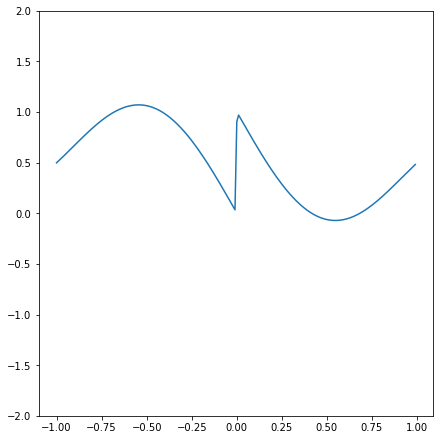

t:  0.001                                 



ValueError: in user code:

    C:\Jupyter\Edge detection\aux_func_V2.py:77 Burgers  *
        return Graph_Burgers2(u, Δt, Δx, CFL, fronteira,network)
    C:\Jupyter\Edge detection\aux_func_V2.py:55 Graph_Burgers2  *
        u1 = u - Δt*DerivadaEspacial(u, Δx, Λ, fronteira,network)
    C:\Jupyter\Edge detection\aux_func_V2.py:98 DerivadaEspacial  *
        U_diff=tf.concat([U[:,2:]-U[:,:-2],U[:,2:]-2*U[:,1:-1]+U[:,:-2]],axis=2)
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:1769 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:1226 concat_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be at least rank 3 but is rank 2 for '{{node while/concat_1}} = ConcatV2[N=2, T=DT_DOUBLE, Tidx=DT_INT32](while/sub_1, while/add_1, while/concat_1/axis)' with input shapes: [1,204], [1,204], [] and with computed input tensors: input[2] = <2>.


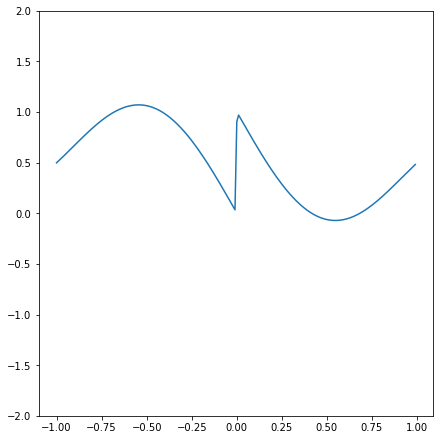

In [6]:
f_test=lambda x: -tf.math.sin(np.pi*x)-0.5*x**3+tf.where(x<0,tf.constant(0.0,dtype=float_pres),tf.constant(1.0,dtype=float_pres))

# k1=5
# k2=2
# a=0.25
# b=0.75

# u1 = lambda x: a*tf.expand_dims(tf.math.sin(k1*pi*x),axis=1)
# u2 = lambda x: (1-a)*tf.expand_dims(tf.math.sin(k2*pi*x),axis=1)



Δx = 0.01
x = tf.range(-1,1,Δx,
            dtype=float_pres)

#u=b*(u1(x)+u2(x))

u=f_test(x)

u=tf.expand_dims(u,axis=0)
u_Z=u[:]

CFL = 0.5
T = 0.001
t = 0.0

fig = plt.figure(1, constrained_layout=True,figsize=(6,6))
ax = fig.add_subplot(1,1,1);
ax.set_ylim(-2, 2);
#ax.set_xlim(0,1);
line=ax.plot(x,tf.squeeze(u))
hfig = display(fig, display_id=True)

while t < T:
    Δt_max=T-t
    Λ = tf.math.reduce_max(tf.abs(u),axis=1,keepdims=True)
    Δt = Δx*CFL/Λ
    Δt = tf.where(Δt > Δt_max,Δt_max,Δt)
    final_layer.t_final.assign(tf.cast(tf.squeeze(Δt),dtype=float_pres))
    u = Network.predict(u)
        
    squeezed_u=tf.squeeze(u)
    t += Δt
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')

    #line.set_xdata(x)
    line[0].set_ydata(squeezed_u.numpy())

    fig.canvas.draw()
    hfig.update(fig)
    #time.sleep(0.01);
    
print('\n')
t=0

while t < T:
    Δt_max=T-t
    Λ = tf.math.reduce_max(tf.abs(u_Z),axis=1,keepdims=True)
    Δt = Δx*CFL/Λ
    Δt = tf.where(Δt > Δt_max,Δt_max,Δt)
    u_Z = Burgers(u_Z,Δt, Δx, CFL, FronteiraPeriodica)
    
    squeezed_u=tf.squeeze(u_Z)
    t += Δt
    print('t: ',tf.squeeze(t).numpy(),'                                ',end='\r')

    #line.set_xdata(x)
    line[0].set_ydata(squeezed_u.numpy())

    fig.canvas.draw()
    hfig.update(fig)
    #time.sleep(0.01);


In [ ]:
def pega_ponto_Z(indice):
    ɛ = 10.0**(-40)
    U=u_Z[:,indice-2:indice+3,:]
    u_stacked=tf.transpose(tf.stack([U,U,U],axis=0),[0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A),axis=3)
    β = tf.transpose(β,[1,2,0])
    
    # WENO-Z

    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    α = (1 + (τ/(β + ɛ))**2) @ B
    soma = tf.math.reduce_sum(α,axis=2,keepdims=True)
    ω = α / soma
    
    ω_Z=ω
    return ω_Z

In [33]:
def pega_ponto_rede(indice):
    ɛ = 10.0**(-40)
    U=u[:,indice-2:indice+3,:]
    U_diff=tf.concat([U[:,2:]-U[:,:-2],U[:,2:]-2*U[:,1:-1]+U[:,:-2]],axis=2)
    beta_weight=tf.transpose(Network.layers[1].network_graph(U_diff),[0,2,1])
    #print('Rede: ',beta_weight.numpy())
    u_stacked=tf.transpose(tf.stack([U,U,U],axis=0),[0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A),axis=3)
    β = tf.transpose(β,[1,2,0])
    
    # Rede Neural
    
    β = β*(beta_weight+0.01)
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    α = (1 + (τ/(β + ɛ))**2) @ B
    soma = tf.math.reduce_sum(α,axis=2,keepdims=True)
    ω = α / soma
    
    ω_Rede=ω
    
    return ω_Rede

In [34]:
n_pontos=9
mid_point=105
y_plot_Rede=np.zeros([n_pontos,3])
y_plot_Z=np.zeros([n_pontos,3])

for i in range(n_pontos):
    indice=int(mid_point-(n_pontos-1)/2+i)
    y_plot_Z[i]=np.squeeze(pega_ponto_Z(indice))
    y_plot_Rede[i]=np.squeeze(pega_ponto_rede(indice))

NameError: name 'pega_ponto_Z' is not defined

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8*2, 6))

ylim=(10**-8,2)

min_x=int(mid_point-(n_pontos-1)/2)
max_x=int(mid_point+(n_pontos+1)/2)

axs[0].plot(x[min_x:max_x],y_plot_Z[:,0],'s',color='red',alpha=1)
axs[0].plot(x[min_x:max_x],y_plot_Z[:,1],'D',color='black',alpha=1)
axs[0].plot(x[min_x:max_x],y_plot_Z[:,2],'o',color='blue',alpha=1)

axs[0].hlines(y=1/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),xmax=max(x[int(100-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),
              color='red',
              linestyles='--')

axs[0].hlines(y=6/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),xmax=max(x[int(100-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),
              color='black',
              linestyles='--')

axs[0].hlines(y=3/10,
              xmin=min(x[int(100-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),xmax=max(x[int(100-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),
              color='blue',
              linestyles='--')

axs[0].set_yscale('log')
axs[0].set_ylim(*ylim)
axs[0].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[0].grid(ls='--')

axs[1].plot(x[min_x:max_x],y_plot_Rede[:,0],'s',color='red',alpha=1)
axs[1].plot(x[min_x:max_x],y_plot_Rede[:,1],'D',color='black',alpha=1)
axs[1].plot(x[min_x:max_x],y_plot_Rede[:,2],'o',color='blue',alpha=1)

axs[1].hlines(y=1/10,
              xmin=x[min_x],xmax=x[max_x],
              color='red',
              linestyles='--')

axs[1].hlines(y=6/10,
              xmin=x[min_x],xmax=max(x[int(100-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),
              color='black',
              linestyles='--')

axs[1].hlines(y=3/10,
              xmin=x[min_x],xmax=max(x[int(100-(n_pontos-1)/2):int(100+(n_pontos+1)/2)]),
              color='blue',
              linestyles='--')

axs[1].set_yscale('log')
axs[1].set_ylim(*ylim)
axs[1].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[1].grid(ls='--')

plt.show()

In [69]:
f_test=lambda x: -tf.math.sin(np.pi*x)-0.5*x**3+tf.where(x<0,tf.constant(0.0,dtype=float_pres),tf.constant(1.0,dtype=float_pres))

Δx = 0.01
x = tf.range(-1,1,Δx,
            dtype=float_pres)

u=f_test(x)
u=tf.expand_dims(u,axis=0)
u=tf.expand_dims(u,axis=2)

In [70]:
def pega_ponto(indice):
    ɛ = 10.0**(-40)
    U=u[:,indice-2:indice+3,:]
    U_diff=tf.concat([U[:,2:]-U[:,:-2],U[:,2:]-2*U[:,1:-1]+U[:,:-2]],axis=2)
    beta_weight=tf.transpose(Network.layers[1].network_graph(U_diff),[0,2,1])
    #print('Rede: ',beta_weight.numpy())
    u_stacked=tf.transpose(tf.stack([U,U,U],axis=0),[0,1,3,2])

    β = tf.math.reduce_sum(u_stacked * (u_stacked @ A),axis=3)
    β = tf.transpose(β,[1,2,0])
    
    # WENO-Z

    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    α = (1 + (τ/(β + ɛ))**2) @ B
    soma = tf.math.reduce_sum(α,axis=2,keepdims=True)
    ω = α / soma
    
    ω_Z=ω
    
    # Rede Neural
    
    β = β*(beta_weight+0.01)
    τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
    α = (1 + (τ/(β + ɛ))**2) @ B
    soma = tf.math.reduce_sum(α,axis=2,keepdims=True)
    ω = α / soma
    
    ω_Rede=ω
    
    return ω_Z,ω_Rede

In [75]:
n_pontos=9
mid_point=100
y_plot_Rede=np.zeros([n_pontos,3])
y_plot_Z=np.zeros([n_pontos,3])

for i in range(n_pontos):
    pontos=pega_ponto(int(mid_point-(n_pontos-1)/2+i))
    y_plot_Z[i]=np.squeeze(pontos[0])
    y_plot_Rede[i]=np.squeeze(pontos[1])

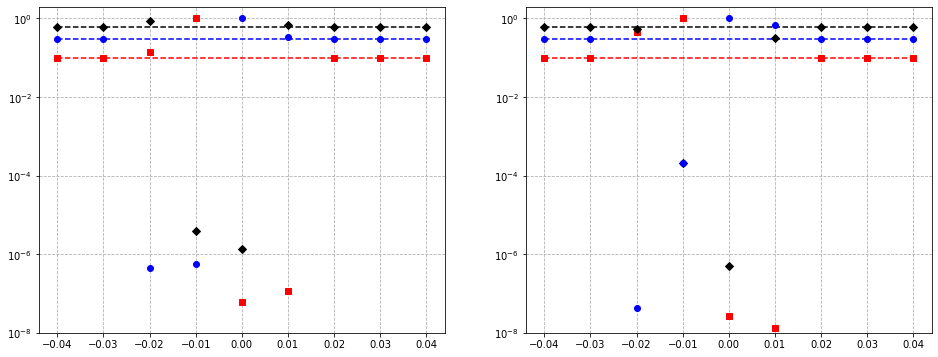

In [101]:
fig, axs = plt.subplots(1,2,figsize=(8*2, 6))

ylim=(10**-8,2)

axs[0].plot(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)],y_plot_Z[:,0],'s',color='red',alpha=1)
axs[0].plot(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)],y_plot_Z[:,1],'D',color='black',alpha=1)
axs[0].plot(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)],y_plot_Z[:,2],'o',color='blue',alpha=1)

axs[0].hlines(y=1/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),xmax=max(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),
              color='red',
              linestyles='--')

axs[0].hlines(y=6/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),xmax=max(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),
              color='black',
              linestyles='--')

axs[0].hlines(y=3/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),xmax=max(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),
              color='blue',
              linestyles='--')

axs[0].set_yscale('log')
axs[0].set_ylim(*ylim)
axs[0].yticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[0].grid(ls='--')

axs[1].plot(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)],y_plot_Rede[:,0],'s',color='red',alpha=1)
axs[1].plot(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)],y_plot_Rede[:,1],'D',color='black',alpha=1)
axs[1].plot(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)],y_plot_Rede[:,2],'o',color='blue',alpha=1)

axs[1].hlines(y=1/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),xmax=max(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),
              color='red',
              linestyles='--')

axs[1].hlines(y=6/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),xmax=max(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),
              color='black',
              linestyles='--')

axs[1].hlines(y=3/10,
              xmin=min(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),xmax=max(x[int(mid_point-(n_pontos-1)/2):int(mid_point+(n_pontos+1)/2)]),
              color='blue',
              linestyles='--')

axs[1].set_yscale('log')
axs[1].set_ylim(*ylim)
axs[1].yticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
axs[1].grid(ls='--')

plt.show()

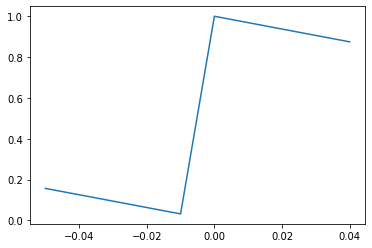

In [37]:
plt.plot(x[95:105],np.squeeze(u)[95:105])